This is the evaluation for our model. We try to implement Object Keypoint Similarity (OKS)
The values of the OKS range between 0 and 1 where 1 would be a perfect overlay between ground truth and predicted key points.
A threshold has to be determined. We sayed that 0.75 would be an accurate threshold, where all OKS values above this value are counted as True Positives.

In [1]:
# Install torch package
# %pip install torch

import torch

def keypoint_similarity(gt_kpts, pred_kpts, sigmas, areas):
    """
    Params:
        gts_kpts: Ground-truth keypoints, Shape: [M, #kpts, 3],
                  where, M is the # of ground truth instances,
                         3 in the last dimension denotes coordinates: x,y, and visibility flag
                          
        pred_kpts: Prediction keypoints, Shape: [N, #kpts, 3]
                   where  N is the # of predicted instances,
 
        areas: Represent ground truth areas of shape: [M,]
 
    Returns:
        oks: The Object Keypoint Similarity (OKS) score tensor of shape: [M, N]
    """
     
    # epsilon to take care of div by 0 exception.
    EPSILON = torch.finfo(torch.float32).eps
     
    # Eucleidian dist squared:
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    # Shape: (M, N, #kpts) --> [M, N, 17]
    dist_sq = (gt_kpts[:,None,:,0] - pred_kpts[...,0])**2 + (gt_kpts[:,None,:,1] - pred_kpts[...,1])**2
 
    # Boolean ground-truth visibility mask for v_i > 0. Shape: [M, #kpts] --> [M, 17]
    vis_mask = gt_kpts[..., 2].int() > 0
 
    # COCO assigns k = 2σ.
    k = 2*sigmas
 
    # Denominator in the exponent term. Shape: [M, 1, #kpts] --> [M, 1, 17]
    denom = 2 * (k**2) * (areas[:,None, None] + EPSILON)
 
    # Exponent term. Shape: [M, N, #kpts] --> [M, N, 17]
    exp_term = dist_sq / denom
 
    # Object Keypoint Similarity. Shape: (M, N)
    oks = (torch.exp(-exp_term) * vis_mask[:, None, :]).sum(-1) / (vis_mask[:, None, :].sum(-1) + EPSILON)
 
    return oks

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB 1.7 MB/s eta 0:02:03
   ---------------------------------------- 0.1/203.1 MB 2.8 MB/s eta 0:01:12
   ---------------------------------------- 0.3/203.1 MB 2.3 MB/s eta 0:01:30
   ---------------------------------------- 0.4/203.1 MB 2.3 MB/s eta 0:01:29
   ---------------------------------------- 0.5/203.1 MB 2.2 MB/s eta 0:01:33
   ---------------------------------------- 0.6/203.1 MB 2.3 MB/s eta 0:01:27
   ---------------------------------------- 0.7/203.1 MB 2.3 MB/s eta 0:01:28
   ---------------------------------------- 0.8/203.1 MB 2.4 MB/s eta 0:01:27
   ---------------------------------------- 1.0/203.1 MB 2.5 MB/s eta 0:01:22
   ---------------------------------------- 1.0/203.1 MB 2.4 MB/s eta 0:01:26
   ---------------------------------------- 1.2/203.1 MB 2.4 MB/s eta 0:01:23
   ---------------------------------------- 1.4/203.1 MB 2.5 MB/s eta 0


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: C:\Users\alice\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [65]:
# Convert inputs to tensors
gt_kpts = torch.tensor([[[
                717.222,
                372.222, 2
            ],
            [
                427.692,
                438.462, 2
            ],
            [
                576.923,
                349.231, 2
            ],
            [
                396.154,
                452.692, 2
            ],
            [
                434.615,
                392.692, 2
            ]]], dtype=torch.float32)
pred_kpts = torch.tensor([[[
                    447.8450012207031,
                    280.7112731933594, 2
                ],
                [
                    293.9934997558594,
                    292.5830993652344, 2
                ],
                [
                    336.610107421875,
                    282.77703857421875, 2
                ],
                [
                    244.15118408203125,
                    311.16961669921875, 2
                ],
                [
                    256.4101257324219,
                    274.6719970703125, 2
                ]]], dtype=torch.float32)
sigmas = torch.tensor([5], dtype=torch.float32)
areas = torch.tensor([1000], dtype=torch.float32)

# Calculate Object Keypoint Similarity (OKS)
oks = keypoint_similarity(gt_kpts, pred_kpts, sigmas, areas)
print(oks)

tensor([[0.7648]])


In [68]:
import json
# Load JSON data
with open('predictions copy.json', 'r') as file:  
    data = json.load(file)

# Iterate over the list of data
for item in data:
    # Parse the JSON data
    predictions = torch.tensor(item['predictions'], dtype=torch.float32)  # Shape: [N, 2]
    ground_truth = torch.tensor(item['ground_truth'], dtype=torch.float32)  # Shape: [M, 2]

    # Ensure both tensors have the same number of dimensions
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
       
    if ground_truth.dim() == 2:
        ground_truth = ground_truth.unsqueeze(0)
        
    #print(predictions)
    #print(ground_truth)
    # Pad predictions and ground truth to have 5 keypoints
    num_kpts = 5
    pred_kpts_padded = torch.zeros(predictions.shape[0], num_kpts, 3)
    gt_kpts_padded = torch.zeros(ground_truth.shape[0], num_kpts, 3)
    pred_kpts_padded[:, :predictions.shape[1], :2] = predictions
    gt_kpts_padded[:, :ground_truth.shape[1], :2] = ground_truth
    pred_kpts_padded[:, :predictions.shape[1], 2] = 2  # visibility flag
    gt_kpts_padded[:, :ground_truth.shape[1], 2] = 2  # visibility flag
    
    #print(pred_kpts_padded)
    #print(gt_kpts_padded)

    # Generate dummy ground truth areas (replace with actual data if available)
    areas = torch.ones(gt_kpts_padded.shape[0]) * 10000000  # Example: uniform area of 1000 for all instances
    # print(areas)

    # Define sigmas for keypoints (replace with specific sigmas if required)
    # COCO keypoint sigmas can be used as a default for human pose: [0.26, 0.25, ..., 0.25] for 5 keypoints
    KPTS_OKS_SIGMAS_COCO = torch.tensor([.25, .25,  .25, .25, .25])/10.0

    sigmas = KPTS_OKS_SIGMAS_COCO  # Use predefined COCO sigmas
    # print(sigmas)
    # Calculate Object Keypoint Similarity (OKS)
    oks = keypoint_similarity(gt_kpts_padded, pred_kpts_padded, sigmas, areas)

    # Output OKS score
    print("Object Keypoint Similarity (OKS) score for image {}: {}".format(item['image_name'], oks))

Object Keypoint Similarity (OKS) score for image Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001865_jpg.rf.f23985f4f085291d5c5b87b1e809d5ec.jpg: tensor([[0.3533]])
Object Keypoint Similarity (OKS) score for image Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000859_jpg.rf.6ccaa8f38724f885c2df6c1319b43706.jpg: tensor([[0.2756]])
Object Keypoint Similarity (OKS) score for image Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000839_jpg.rf.4aae2f7ef06d9a0683ece13868fd6421.jpg: tensor([[0.2459]])
Object Keypoint Similarity (OKS) score for image Hypsicorypha-gracilis_D3_F4_S1_23-07-18_C001H001S0001002506_jpg.rf.bb735e57828520510ba566104660f2ea.jpg: tensor([[0.2447]])
Object Keypoint Similarity (OKS) score for image Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001991_jpg.rf.edf9cbbf8856709d0f33c113e285410e.jpg: tensor([[0.3533]])
Object Keypoint Similarity (OKS) score for image Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001002018_jpg.rf.691c6ee289

**Visualizing **

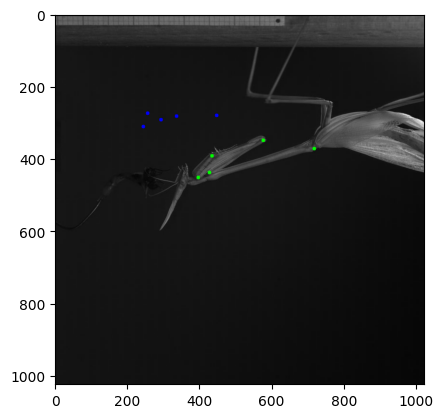

In [72]:
# Install opencv-python package
# %pip install opencv-python

import cv2
import matplotlib.pyplot as plt

# Ensure the correct path to the image
image_path = "C:/Users/alice/OneDrive/Desktop/Masterstudium/MachineLearning_TensorFlow/MantisAI/3_Model/MantisAIData/train/Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001865_jpg.rf.f23985f4f085291d5c5b87b1e809d5ec.jpg"
img = cv2.imread(image_path)

if img is not None:
    for kpt in gt_kpts[0]:
        x, y, _ = kpt
        cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)  # Ground truth: green
    for kpt in pred_kpts[0]:
        x, y, _ = kpt
        cv2.circle(img, (int(x), int(y)), 5, (255, 0, 0), -1)  # Predictions: blue
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print(f"Error: Unable to load image at {image_path}")